# Wrangling Data with MongoDb


In [27]:
from pprint import PrettyPrinter
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Instantiate a PrettyPrinter, and assign it to the variable pp
pp = PrettyPrinter(indent=2)

## Prepare Data

### Connect

In [7]:
#Create a client that connects to the database running at localhost on port 27017.
client = MongoClient(host="localhost", port=27017)

An iterator is an object that provides a way to access the elements of a collection (such as a list, tuple, set, or dictionary) sequentially, one at a time, without the need to know the underlying structure of the collection.

Now lets get the List of the databases in server using PyMongo

In [8]:
# Print output using pprint.
pp.pprint(list(client.list_databases()))


[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 7000064},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 12288},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728},
  {'empty': False, 'name': 'wqu-abtest', 'sizeOnDisk': 585728}]


Since our interest is on Air quality, I'll now assign the "air-quality" database to the variable db.

In [9]:
db = client["air-quality"]

Next I'll Use the list_collections method to print a list of the collections available in db.

In [10]:
for c  in db.list_collections():
    print(c["name"])

system.views
lagos
system.buckets.lagos
nairobi
system.buckets.nairobi
dar-es-salaam
system.buckets.dar-es-salaam


My interest is "Lagos" so I'll assign the "Lagos" collection in db to the variable name lagos.

In [11]:
lagos = db["lagos"]

A MongoDB document is an individual record of data in a collection, and is the basic unit of analysis in MongoDB. Documents come with metadata that helps us understand what the document is.Meta Data simply refers to data about the data collected.

In [12]:
# Use the count_documents method to see how many documents are in the lagos collection
lagos.count_documents({})

166496

Databases are designed to work with either structured data or semi-structured data.Data is semi-structured when it has some kind of organizing logic, but that logic can't be displayed using rows and columns.

In [13]:
# using the find_one method to Retrieve a document from a collection using PyMongo.
result = lagos.find_one({})
pp.pprint(result)

{ '_id': ObjectId('6334b0f18c51459f9b1d955d'),
  'metadata': { 'lat': 6.501,
                'lon': 3.367,
                'measurement': 'temperature',
                'sensor_id': 10,
                'sensor_type': 'DHT11',
                'site': 4},
  'temperature': nan,
  'timestamp': datetime.datetime(2018, 1, 7, 7, 7, 3, 88000)}


Next I'll Use the distinct method to determine how many sensor sites are included in the lagos collection.

In [14]:
lagos.distinct("metadata.site")

[4, 3]

Notice that in order to grab the "site" number, we needed to include the "metadata" tag.

This tells us that there are 2 sensor sites in Lagos: one labeled 3 and the other labeled 4.

Let's go further. We know that there are two sensor sites in Lagos, but we don't know how many documents are associated with each site. To find that out, we'll use the count_documents method for each site.

In [15]:
print("Documents from site 3:", lagos.count_documents({"metadata.site": 3}))
print("Documents from site 4:", lagos.count_documents({"metadata.site": 4}))

Documents from site 3: 140586
Documents from site 4: 25910


Now that we know how many documents are associated with each site, let's keep drilling down and find the number of readings for each site. We'll do this with the aggregate method



In [16]:
result = lagos.aggregate(
    # Here's the `$` and the `"_id"`
    [{"$group": {"_id": "$metadata.site", "count": {"$count": {}}}}]
)
pp.pprint(list(result))

[{'_id': 4, 'count': 25910}, {'_id': 3, 'count': 140586}]


First, you'll notice that there are several dollar signs ($) in the list. This is telling the collection that we want to create something new. Here, we're saying that we want there to be a new group, and that the new group needs to be updated with data from metadata.site, and then updated again with data from count.

There's also a new field: "_id". In PyMongo, "_id" is always the primary key. Primary keys are the fields which contain values that uniquely identify each row in a table.

Next I'll Use the distinct method to determine how many types of measurements have been taken in the lagos collection.

In [17]:
lagos.distinct("metadata.measurement")

['humidity', 'temperature', 'P1', 'P2']

With that information in mind. Since we're really interested in measures of air quality, let's take a look at the P2 values in the "lagos" collection. P2 measures the amount of particulate matter in the air, which in this case is something called PM 2.5. to minimize ambiguity,let's use the find method and use limit to make sure we only get back the first 3.

In [18]:
result = lagos.find({"metadata.measurement": "P2"}).limit(3)
pp.pprint(list(result))

[ { 'P2': 14.42,
    '_id': ObjectId('6334b0f28c51459f9b1de145'),
    'metadata': { 'lat': 6.501,
                  'lon': 3.367,
                  'measurement': 'P2',
                  'sensor_id': 6,
                  'sensor_type': 'PPD42NS',
                  'site': 4},
    'timestamp': datetime.datetime(2018, 1, 7, 7, 7, 3, 39000)},
  { 'P2': 19.66,
    '_id': ObjectId('6334b0f28c51459f9b1de146'),
    'metadata': { 'lat': 6.501,
                  'lon': 3.367,
                  'measurement': 'P2',
                  'sensor_id': 6,
                  'sensor_type': 'PPD42NS',
                  'site': 4},
    'timestamp': datetime.datetime(2018, 1, 7, 7, 11, 23, 870000)},
  { 'P2': 24.79,
    '_id': ObjectId('6334b0f28c51459f9b1de147'),
    'metadata': { 'lat': 6.501,
                  'lon': 3.367,
                  'measurement': 'P2',
                  'sensor_id': 6,
                  'sensor_type': 'PPD42NS',
                  'site': 4},
    'timestamp': datetime.datetime(2

Next I'll Use the aggregate method to calculate how many readings there are for each type ("humidity", "temperature", "P2", and "P1") in both site [4,3]

In [19]:
# for site 4
result = result = lagos.aggregate(
    [   
        {"$match": {"metadata.site": 4}},
        {"$group": {"_id": "$metadata.measurement", "count": {"$count": {}}}}
    ]


)

pp.pprint(list(result))

[ {'_id': 'humidity', 'count': 6477},
  {'_id': 'temperature', 'count': 6477},
  {'_id': 'P1', 'count': 6478},
  {'_id': 'P2', 'count': 6478}]


In [20]:
# for site 3
result = result = lagos.aggregate(
    [   
        {"$match": {"metadata.site": 3}},
        {"$group": {"_id": "$metadata.measurement", "count": {"$count": {}}}}
    ]


)

pp.pprint(list(result))

[ {'_id': 'humidity', 'count': 35147},
  {'_id': 'temperature', 'count': 35147},
  {'_id': 'P1', 'count': 35146},
  {'_id': 'P2', 'count': 35146}]


## Import

Next I'll Use the find method to retrieve the PM 2.5 readings from site 3 which  is the most populated site.Since we won't need the metadata for our model, I'll use the projection argument to limit the results to the "P2" and "timestamp" keys only.

In [21]:
result = lagos.find(
       {"metadata.site": 3, "metadata.measurement": "P2"},
       projection={"P2":1, "timestamp": 1, "_id": 0}

)
pp.pprint(result.next())

{'P2': 0.01, 'timestamp': datetime.datetime(2018, 10, 1, 0, 0, 52, 906000)}


Next I'll create a wrangle function that will automate the data cleaning process.And every block of code used for cleaning will be updated in the function.

In [22]:
def wrangle(collection):
    results = lagos.find(
        {"metadata.site": 3, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    df = pd.DataFrame(results).set_index("timestamp")

    #localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Lagos")
    
    return df

In [23]:
df = wrangle(lagos)
df.head(10)

,P2
timestamp,
2018-10-01 00:00:52.906,0.01
2018-10-01 00:04:20.554,0.01
2018-10-01 00:07:47.504,0.01
2018-10-01 00:11:14.382,0.01
2018-10-01 00:14:41.239,0.01
2018-10-01 00:18:05.938,0.01
2018-10-01 00:21:34.131,0.01
2018-10-01 00:24:59.809,0.01
2018-10-01 00:28:26.467,0.01


Next I'll add to my wrangle function so that the DatetimeIndex for df is localized to the correct timezone, "Africa/Lagos".

In [24]:
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Lagos")
df.head()

,P2
timestamp,
2018-10-01 01:00:52.906000+01:00,0.01
2018-10-01 01:04:20.554000+01:00,0.01
2018-10-01 01:07:47.504000+01:00,0.01
2018-10-01 01:11:14.382000+01:00,0.01
2018-10-01 01:14:41.239000+01:00,0.01


Now I'll add the code to my wrangle function.

Next I'll create a boxplot using pandas in order to identify outliers.

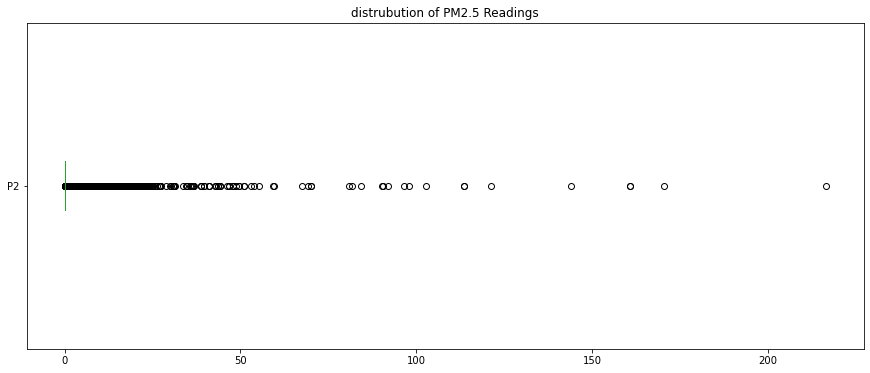

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box", vert = False, title="distrubution of PM2.5 Readings");

From the visualization we see that every PM2.5 is lower that 500 and from research carried out, we consider over 500 PM2.5 readings hazardous. since we have no reading in that region we carry on with our analysis. 